# This is a tutorial notebook for the `auto_oo` package

The goal of this package is to provide the user with cost functions representing ground state energies of electronic structure Hamiltonians, that are auto-differentiable with respect to both quantum circuit ($\vec{\theta}$) and classical orbital parameters ($\vec{\kappa}$). See [our paper](https://arxiv.org/abs/2304.06070) and the other example notebook for more applications of this code.

To run this tutorial you need to install the auto_oo package, following the instructions in README file of this repository.

## Code structure

```
auto_oo
├── ansatze
│   ├── __init__.py
│   ├── kUpCCD.py -│ Different Ansätze that are modified from Pennylane to exclude single excitations,
│   └── uccd.py   -│ as we can deal with them in the classical orbital-optimization.
├── __init__.py
├── moldata_pyscf.py - Interface to pyscf for extracting integrals and overlap matrices
│                      (and optionally do Hartree-Fock or CASSCF to compare results)
├── pqc.py - Here we generate parameterized quantum circuits. There is a method to extract states
│            and 1- and 2-Reduced Density Matrices (RDMs)
├── oo_energy.py - Here the main code lives. This class is used to calculate auto-differentiable
│                  energies from 1- and 2-RDMs. It can compute analytical gradients and Hessians
│                  with respect to orbital rotations. It has a method to perform orbital optimization
│                  using the newton_raphson module. It is agnostic to the method used to retrieve RDMs.
├── oo_pqc.py - A child of the OO_energy class. Here the Parameterized circuit and the oo_energy
│               come together and with this the user is able to extract orbital and quantum
│               circuit parameter gradients and (composite) Hessians. It has a method to perform
│               full (circuit and orbital) optimization with Newton-Raphson steps.
├── noisy_oo_pqc.py Adaptation of the above class to include noisy gradients and Hessians used
│                   in our sampling noise simulations.
└── utils
    ├── active_space.py - Functions for computing active space integrals and fermionic operators
    ├── __init__.py
    ├── miscellaneous.py - Some miscellaneous functions to enable sparse matrices
    └── newton_raphson.py - Performs single Newton-Raphson steps (optionally with regularization) using
                            gradients and Hessians
```

In [61]:
import auto_oo
import pennylane as qml
import numpy as np
import openfermion
import cirq
import matplotlib.pyplot as plt

import torch
torch.set_default_tensor_type(torch.DoubleTensor) # Required for compatibility with PennyLane

import warnings
warnings.simplefilter("ignore", UserWarning) # Ignore a pytorch warning about sparse matrices being in beta state

To perform the orbital-optimized VQE on a molecular model in `auto_oo`, we need to construct the follwing building blocks:
- A parameterized quantum circuit (PQC) [class `auto_oo.Parameterized_circuit`)]
- A model of the molecule, containing molecular data [class `auto_oo.Moldata_pyscf`]
- An auto-differentiable active space Hamiltonian [class `auto_oo.OO_energy`]

We can then combine these all in the class `auto_oo.OO_pqc`, which allows to perform concurrent optimization of the PQC parameters and orbitals.

# Defining the PQC (PennyLane interface)

First, let us define the parameterized quantum circuit. 
The class `auto_oo.Parameterized_circuit` has as main goal to extract one- and two-electron reduced density matrices (RDMs) given a set of quantum circuit parameters. It natively supports multiple standard Ansatzes, like UCC(S)D and Number-preserving Fabrics. One can also input a custom `pennylane.QNode` that outputs a quantum state, see the documentation of the class for more information. Both the parameter vector and output state are `torch.Tensor` objects, that are compatible with automatic differentation in pytorch.


To construct the PQC, we need to define the size of the active space we want to use and the kind of PQC ansatz.
We also need to define a PennyLane device. 
(For more information how pennylane handles quantum circuits, see for example https://pennylane.ai/qml/demos/tutorial_qubit_rotation.html.)

In [62]:
ncas = 3 # Number of active orbitals
nelecas = 4 # Number of active electrons

ansatz = 'np_fabric' # One of the native ansatze.
n_layers = 2 # Number of layers in the GateFabric ansatz

dev = qml.device('default.qubit', wires=2*ncas)

# Construct the PQC
pqc = auto_oo.Parameterized_circuit(ncas, nelecas, dev, ansatz=ansatz, n_layers=n_layers)

In [63]:
# Print the circuit for a random theta vector.
np.random.seed(100)
theta_test = torch.Tensor([np.random.uniform(0., 2*np.pi) for x in range(pqc.theta_shape)])
print(pqc.draw_circuit(theta_test))

0: ──X─╭G²(0.00)─╭OrbitalRotation(0.00)──────────────────────────────────╭G²(2.67)
1: ──X─├G²(0.00)─├OrbitalRotation(0.00)──────────────────────────────────├G²(2.67)
2: ──X─├G²(0.00)─├OrbitalRotation(0.00)─╭G²(3.41)─╭OrbitalRotation(1.75)─├G²(2.67)
3: ──X─╰G²(0.00)─╰OrbitalRotation(0.00)─├G²(3.41)─├OrbitalRotation(1.75)─╰G²(2.67)
4: ─────────────────────────────────────├G²(3.41)─├OrbitalRotation(1.75)──────────
5: ─────────────────────────────────────╰G²(3.41)─╰OrbitalRotation(1.75)──────────

──╭OrbitalRotation(5.31)──────────────────────────────────┤  State
──├OrbitalRotation(5.31)──────────────────────────────────┤  State
──├OrbitalRotation(5.31)─╭G²(0.03)─╭OrbitalRotation(0.76)─┤  State
──╰OrbitalRotation(5.31)─├G²(0.03)─├OrbitalRotation(0.76)─┤  State
─────────────────────────├G²(0.03)─├OrbitalRotation(0.76)─┤  State
─────────────────────────╰G²(0.03)─╰OrbitalRotation(0.76)─┤  State


To extract the state from the pqc class, call the attribute `qnode` that returns a `torch.Tensor`.

In [64]:
state = pqc.qnode(theta_test)
# We can visualize the state in dirac notation with the help of cirq. For this, convert it to a numpy array first:
print(cirq.dirac_notation(state.detach().numpy(), decimals=4))

0.3447|001111⟩ + 0.2995|011011⟩ + 0.0921|011110⟩ - 0.2995|100111⟩ - 0.0921|101101⟩ - 0.325|110011⟩ - 0.4976|110110⟩ + 0.4976|111001⟩ - 0.2897|111100⟩


## Extracting RDMs

From this state, we can extract the spin-restricted 1- and 2-RDMS, defined by:

$$
\begin{align}
    \gamma_{pq}(\boldsymbol{\theta}) &= \langle\psi(\boldsymbol{\theta})|E_{pq}|\psi(\boldsymbol{\theta})\rangle\\
    \Gamma_{pqrs}(\boldsymbol{\theta}) &= \langle\psi(\boldsymbol{\theta})|e_{pqrs}|\psi(\boldsymbol{\theta})\rangle
\end{align}
$$

where $E_{pq} = \sum_\sigma a_{p\sigma}^\dagger a_{q\sigma}$ and $e_{pqrs} = \sum_{\sigma \tau} a_{p\sigma}^\dagger a_{r\tau}^\dagger a_{s\tau} a_{q\sigma} = E_{pq}E_{rs} - \delta_{qr}E_{ps}$.

From these, we will later define the energy cost-function.

We can visualize the 1-RDM using matplotlib

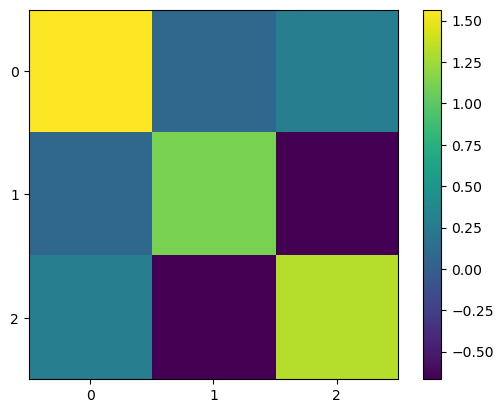

In [65]:
one_rdm, two_rdm = pqc.get_rdms_from_state(state)

plt.imshow(one_rdm)
plt.yticks(list(range(ncas)))
plt.xticks(list(range(ncas)))
plt.colorbar()
plt.show()

# Building the molecular model (PySCF interface)

Lets use the molecule formaldimine as an example. The `auto_oo` package is interfaced with PySCF to extract molecular properties using `auto_oo.Moldata_pyscf`. ![picture](formaldimine.png)

In [66]:
def get_formal_geo(alpha, phi):
    variables = [1.498047, 1.066797, 0.987109, 118.359375] + [alpha, phi]
    geom = """
                    N
                    C 1 {0}
                    H 2 {1}  1 {3}
                    H 2 {1}  1 {3} 3 180
                    H 1 {2}  2 {4} 3 {5}
                    """.format(*variables)
    return geom

In [67]:
alpha = 140
phi = 80
basis = 'sto-3g' # You can try a bigger basis set if you want
mol = auto_oo.Moldata_pyscf(get_formal_geo(alpha,phi), basis)

In [68]:
print(get_formal_geo(alpha, phi))


                    N
                    C 1 1.498047
                    H 2 1.066797  1 118.359375
                    H 2 1.066797  1 118.359375 3 180
                    H 1 0.987109  2 140 3 80
                    


The class `auto_oo.Moldata_pyscf` stores the integrals and the overlap matrix; for example:

(13, 13)
(13, 13, 13, 13)


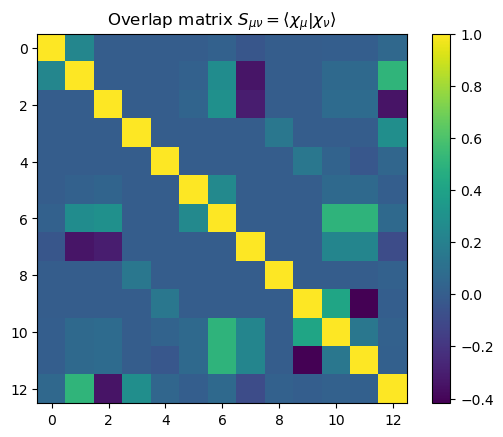

In [69]:
print(mol.int1e_ao.shape)
print(mol.int2e_ao.shape)
plt.title(r'Overlap matrix $S_{\mu \nu} = \langle \chi_\mu | \chi_\nu \rangle$')
plt.imshow(mol.overlap)
plt.colorbar()
plt.show()

We can also run Hartree-Fock, CASCI or CASSCF:

In [70]:
mol.run_rhf()
mol.run_casci(ncas, nelecas)
mol.run_casscf(ncas, nelecas)

In [71]:
print(f'Hartree-Fock energy: {mol.hf.e_tot:.6f}')
print(f'CASCI energy:        {mol.casci.e_tot:.6f}')
print(f'CASSCF energy:       {mol.casscf.e_tot:.6f}')

Hartree-Fock energy: -92.663722
CASCI energy:        -92.736706
CASSCF energy:       -92.749954


# Energy with parameterized orbitals

To extract the active space Hamiltonian in different molecular orbital bases, we provide the `auto_oo.OO_energy` class.
The class is built from a `auto_oo.Moldata_pyscf` object defining the molecular model, along with a definition of the active space.
This class also stores a defintion of the current MO coefficients, which can be provided on construction.
If no MO coefficients are provided, the constructor defaults to the Hatrtee-Fock molecular orbitals.

In [72]:
oo_energy = auto_oo.OO_energy(mol, ncas, nelecas)

In [73]:
# Test if the MOs are indeed HF:
np.allclose(oo_energy.mo_coeff.detach().numpy(), mol.hf.mo_coeff)
# Note: we use the `.detach().numpy()` method to convert a PyTorch Tensor to a numpy array

True

The most important functionality of `auto_oo` is to give an auto-differentiable energy cost function in an active space. The energy will both depend on the 1- and 2-RDMs and the Molecular coefficients defined by the MOs. The set of MOs are in general written as:

$$
\phi_p (C, \mathbf{R}) = \sum_{\mu} \chi_\mu(\mathbf{R}) C_{\mu p}
$$

We can transform these MOs with a unitary matrix, parameterized exponentially by $\kappa$:

$$
\phi^\prime_q = \sum_p \phi_p [e^{-\kappa}]_{pq}
$$

where $\kappa$ is an anti-symmetric matrix with $N(N-1)/2$ parameters. This amounts to transforming $C\rightarrow C e^{-\kappa}$.

The total energy is given by:

$$
    E(C, \gamma, \Gamma) = E_{\rm nuc} + E_{\rm core}(C) +
    \sum_{tu}\tilde{h}_{tu}(C) \gamma_{tu} +
    \sum_{tuvw} g_{tuvw}(C) \Gamma_{tuvw}
$$

where $E_{core}$ is the mean-field energy of the core (doubly-occupied) orbitals, $\tilde{h}_{pq}$ is contains the active one-body terms plus the mean-field interaction of core-active orbitals and $g_{pqrs}$ are the active integrals in chemist ordering. 

This function is then differentiable to a transformation of the MOs $\kappa$, and the one- and two-RDMs $\gamma$ and $\Gamma$. The single gradient and hessian with respect to orbital rotations,  $\frac{\partial E}{\partial \kappa_{pq}}$ and $\frac{\partial^2 E}{\partial \kappa_{pq} \partial \kappa_{rs}}$, can also be obtained analytically. Of the total parameter vector $\kappa$, rotations from occupied to occupied and virtual to virtual are redundant and set to zero.

We can compute the active space energy with the RDMs from the `pqc` class. In that case, they are dependent on the circuit parameter vector $\boldsymbol{\theta}$.

In [74]:
energy_random_theta = oo_energy.energy_from_mo_coeff(oo_energy.mo_coeff, one_rdm, two_rdm).item()
print(f'Energy with a random theta: {energy_random_theta:.6f}')

Energy with a random theta: -92.358872


## Optimizing the orbitals (without optimizing the PQC)

Of course, the energy with a random theta is not great. While the `auto_oo` package is really only meant to give you primitives of energies and parameter derivatives, there is a method included to optimize the orbitals, that uses the `newton_raphson` module. For more information, we refer you to the documentation of the `newton_raphson` module. We can optimize the orbitals for this specific state by calling the `orbital_optimization` method.

In [75]:
energy_l = oo_energy.orbital_optimization(one_rdm, two_rdm)

iter = 000, energy = -92.378028235148
iter = 001, energy = -92.526721633693
iter = 002, energy = -92.632765073709
iter = 003, energy = -92.671480440563
iter = 004, energy = -92.686950776806
iter = 005, energy = -92.715930934935
iter = 006, energy = -92.726840714468
iter = 007, energy = -92.735427552560
iter = 008, energy = -92.742439333920
iter = 009, energy = -92.743200962031
iter = 010, energy = -92.743229248081
iter = 011, energy = -92.743229391559
iter = 012, energy = -92.743229391563


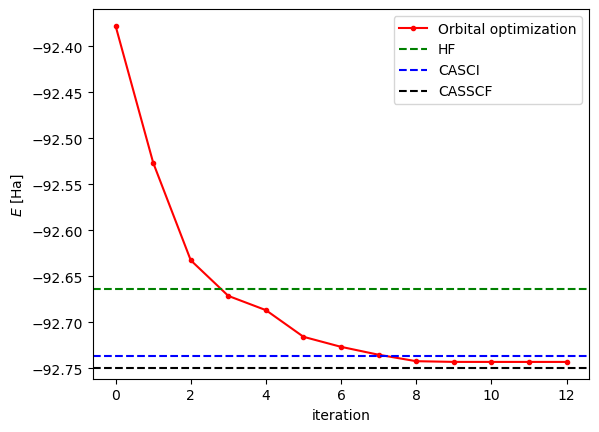

In [76]:
plt.plot(energy_l, '.-r', label='Orbital optimization')
plt.axhline(mol.hf.e_tot, ls='--', c='g', label='HF')
plt.axhline(mol.casci.e_tot, ls='--', c='b', label='CASCI')
plt.axhline(mol.casscf.e_tot, ls='--', c='k', label='CASSCF')
plt.xlabel('iteration')
plt.ylabel(r'$E$ [Ha]')
plt.legend()
plt.show()

Note that the resulting energy could be higher or lower than both the CASCI or Hartree-Fock result, because we chose a random value for the PQC parameter theta!
You can change the np.random seed and re-run all the cells above to get a different result.

## Optimizing a circuit 
While this gives us optimized orbitals for a random theta, we typically also want to optimize the PQC parameters. 
Here, we focus on optimizing the PQC parameters while keeping the orbitals fixed to Hartree-Fock.
(This is analogous to CASCI.)
Although this is not a core functionality of `auto_oo`, we can easily implement this by importing and optimizer from PyTorch.

First, extract the active space Hamiltonian

In [80]:
# We can extract the Hamiltonian as an openfermion FermionOperator for the Hartree-Fock orbitals
c0, c1, c2 = oo_energy.get_active_integrals(torch.from_numpy(mol.hf.mo_coeff))
fermionic_cas_hamiltonian = auto_oo.fermionic_cas_hamiltonian(c0, c1, c2)

In [81]:
# Compute the eigenvalues to make sure we have the correct Hamiltonian
fch_energies = openfermion.eigenspectrum(fermionic_cas_hamiltonian)
e_0 = fch_energies[0]
print(f'Based on HF orbitals, the CASCI ground state energy is: {e_0:.6f}')
print(f'CASCI energy from PySCF:                                {mol.casci.e_tot:.6f}')

Based on HF orbitals, the CASCI ground state energy is: -92.736706
CASCI energy from PySCF:                                -92.736706


Now we can convert it to a pennylane observable to measure with a `qml.qnode`. First convert it to a QubitOperator with the Jordan-Wigner transformation.

In [82]:
qubit_cas_hamiltonian = openfermion.jordan_wigner(fermionic_cas_hamiltonian)
pennylane_cas_hamiltonian = qml.qchem.import_operator(qubit_cas_hamiltonian)

For the ansatz lets choose the same one that is inside the `pqc` class, the GateFabric ansatz. We can optimize it with the Adam optimizer from PyTorch. This automatically computes the gradient at every step. It can do so quickly because of automatic-differentation of the circuit.

In [83]:
@qml.qnode(dev, interface='torch', diff_method='backprop')
def cost_function(theta):
    """ Outputs NP fabric ansatz state"""
    qml.GateFabric(theta,
                   wires=pqc.wires, init_state=pqc.hfstate, include_pi=False)
    return qml.expval(pennylane_cas_hamiltonian)

In [90]:
theta = torch.zeros(pqc.full_theta_shape)
theta.requires_grad = True

energy_init = cost_function(theta).item()
print(f'Zero parameters give us an energy of:       {energy_init:.6f}')
print(f'Should be equal to the Hartree-Fock energy: {mol.hf.e_tot:.6f}')

Zero parameters give us an energy of:       -92.663722
Should be equal to the Hartree-Fock energy: -92.663722


In [91]:
# Define hyperparameters and optimizer of the VQE
max_iterations = 100
conv_tol = 1e-8
stepsize = 0.03
e_min = 1e99
opt = torch.optim.Adam([theta],lr=stepsize)

# Save results in
opt_trajectory = [energy_init]
theta_trajectory = [theta.detach().clone()]

In [92]:
for n in range(max_iterations):
    # At every step, clear the gradient and do a backward pass to compute
    # the gradient. Then perform one step of the Adam optimizer.
    opt.zero_grad()
    loss = cost_function(theta)
    loss.backward()
    opt.step()

    curr_energy = cost_function(theta).item()

    if n%10 == 0: print('iter, e =', n, curr_energy)
    opt_trajectory.append(curr_energy)
    theta_trajectory.append(theta.detach().clone())

    if curr_energy < e_min:
        e_min = curr_energy
        n_min = n
        theta_min = theta.detach().clone()
    
    # Convergence condition
    if n > 1:
        if (np.abs(opt_trajectory[-1] - opt_trajectory[-2])\
            < conv_tol):
            print("\nVQE converged")
            print(f'VQE energy: {opt_trajectory[-1]:.6f}')
            print(f'CASCI energy:  {mol.casci.e_tot:.6f}')
            break


iter, e = 0 -92.66636738290025
iter, e = 10 -92.68176649295445
iter, e = 20 -92.7025827609067
iter, e = 30 -92.7242786569488
iter, e = 40 -92.73285599340959
iter, e = 50 -92.73526601189752
iter, e = 60 -92.73598495864195
iter, e = 70 -92.73650222690644
iter, e = 80 -92.73661975195785
iter, e = 90 -92.73669470978446


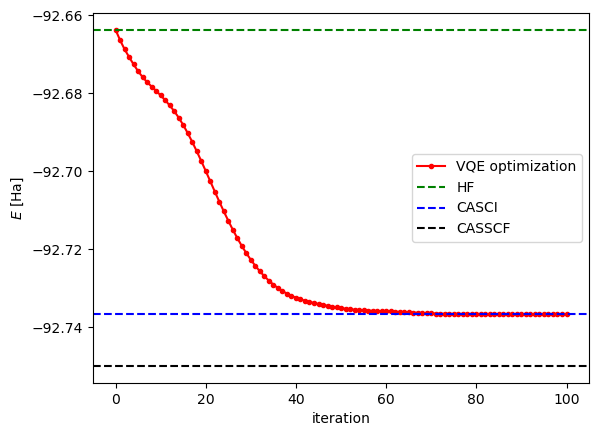

In [93]:
plt.plot(opt_trajectory, '.-r', label='VQE optimization')
plt.axhline(mol.hf.e_tot, ls='--', c='g', label='HF')
plt.axhline(mol.casci.e_tot, ls='--', c='b', label='CASCI')
plt.axhline(mol.casscf.e_tot, ls='--', c='k', label='CASSCF')
plt.xlabel('iteration')
plt.ylabel(r'$E$ [Ha]')
plt.legend()
plt.show()

# Combined optimization: the Orbital Optimized VQE

In this section, we realize concurrent optimization of the PQC parameters and orbitals.
We do this by combining the parameterized quantum circuit (`auto_oo.Parameterized_circuit`, with parameter $\theta$) and parameterized-orbital cost function (`auto_oo.OO_energy`, with parameter $\kappa$) together in the class `auto_oo.OO_pqc`.
This class allows  to extract gradients and Hessians with respect to both parameters (including mixed Hessian terms).

In [94]:
oo_pqc = auto_oo.OO_pqc(pqc, mol, ncas, nelecas, freeze_active=True)

We can now retrieve the full Hessian to all the parameters. It can be written as:

$$
\begin{align}
    \nabla_{(\boldsymbol{\theta},\boldsymbol{\kappa})} E 
    &= (\nabla_{\boldsymbol{\theta}}E, \nabla_{\boldsymbol{\kappa}} E)  \label{eq:composite-gradient}
    \\
    \nabla^2_{(\boldsymbol{\theta},\boldsymbol{\kappa})} E 
    &= 
    \begin{bmatrix}
        \nabla^2_{\boldsymbol{\theta}}E 
        & \nabla_{\boldsymbol{\kappa}}\nabla_{\boldsymbol{\theta}} E\\
        (\nabla_{\boldsymbol{\kappa}}\nabla_{\boldsymbol{\theta}} E)^\intercal
        & \nabla^2_{\boldsymbol{\kappa}} E 
    \end{bmatrix}.  \label{eq:composite-hessian}
\end{align}
$$

The off-diagonal blocks are computed by auto-differentation of the analytical gradient of $\kappa$ w.r.t. $\theta$ 

In [95]:
print("Number of thetas:", pqc.theta_shape)
print("Number of kappas:", oo_pqc.n_kappa)
print("Shape of the full Hessian matrix:", oo_pqc.full_hessian(theta_test).shape)

Number of thetas: 6
Number of kappas: 54
Shape of the full Hessian matrix: torch.Size([60, 60])


To perform full optimization (i.e. OO-VQE) of both circuit and orbital parameters with the Newton-raphson method, we can call the `full_optimizaton` method of `OO_pqc`.

In [96]:
theta_zero = pqc.init_zeros()
energy_l, theta_l, kappa_l, oao_mo_coeff_l, hess_eig_l = oo_pqc.full_optimization(theta_zero)

iter = 000, energy = -92.663721935563
iter = 001, energy = -92.703324482233
iter = 002, energy = -92.726527375978
iter = 003, energy = -92.729022522237
iter = 004, energy = -92.735923008241
iter = 005, energy = -92.748380724406
iter = 006, energy = -92.748584904682
iter = 007, energy = -92.749173350537
iter = 008, energy = -92.749213296610
iter = 009, energy = -92.749224993134
iter = 010, energy = -92.749249231650
iter = 011, energy = -92.749283606046
iter = 012, energy = -92.749299386336
iter = 013, energy = -92.749665413926
iter = 014, energy = -92.749825884720
iter = 015, energy = -92.749918773172
iter = 016, energy = -92.749929359783
iter = 017, energy = -92.749952958209
iter = 018, energy = -92.749953680752
iter = 019, energy = -92.749953681394
iter = 020, energy = -92.749953681394
optimization finished.
E_fin = -92.74995368139409


Indeed, we should have reached the CASSCF energy, given that the ansatz can exactly represent the ground state:

In [97]:
print("\nOO-VQE converged")
print(f'OO-VQE energy: {energy_l[-1]:.6f}')
print(f'CASSCF energy: {mol.casscf.e_tot:.6f}')


OO-VQE converged
OO-VQE energy: -92.749954
CASSCF energy: -92.749954


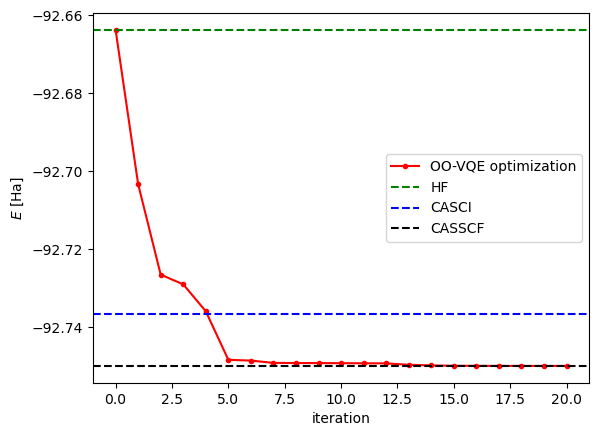

In [98]:
plt.plot(np.append(mol.hf.e_tot, energy_l), '.-r', label='OO-VQE optimization')
plt.axhline(mol.hf.e_tot, ls='--', c='g', label='HF')
plt.axhline(mol.casci.e_tot, ls='--', c='b', label='CASCI')
plt.axhline(mol.casscf.e_tot, ls='--', c='k', label='CASSCF')
plt.xlabel('iteration')
plt.ylabel(r'$E$ [Ha]')
plt.legend()
plt.show()

We see here an important parameter of Newton-Rapshon optimization: the lowest eigenvalue of the Hessian. This determines the rate of convergence. 

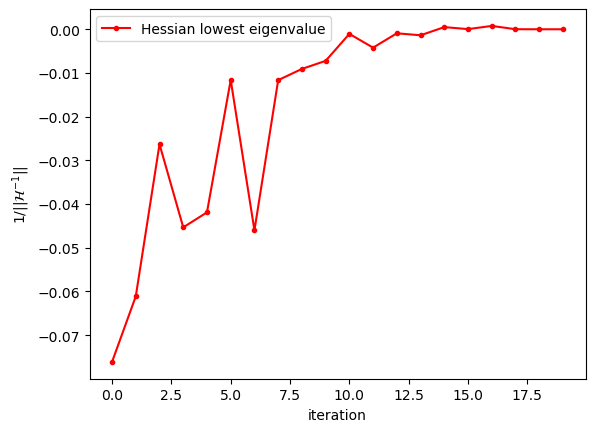

In [99]:
plt.plot(hess_eig_l, '.-r', label='Hessian lowest eigenvalue')
plt.xlabel('iteration')
plt.ylabel(r'$1/||\mathcal{H}^{-1}||$')
plt.legend()
plt.show()

We can also plot the PQC parameter values during the optization:

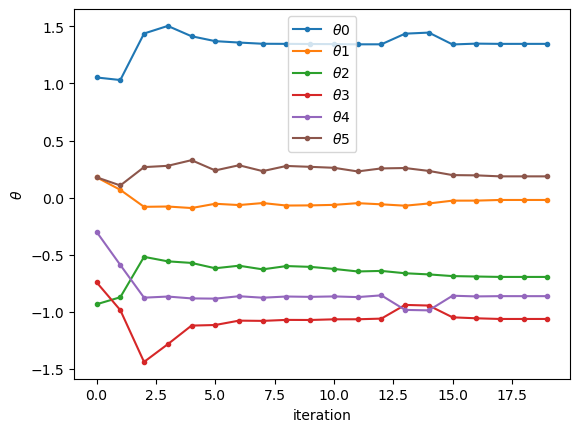

In [100]:
for i in range(len(theta_test)):
    plt.plot([theta_l[j][i] for j in range(len(theta_l))], '.-', label=f'$\\theta {i}$')
plt.xlabel('iteration')
plt.ylabel(r'$\theta$')
plt.legend()
plt.show()